In [1]:
import os
import re
import numpy as np
import tensorflow as tf

from random import shuffle
from glob import glob
from tqdm import tqdm
from bs4 import BeautifulSoup
from itertools import chain
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

In [2]:
# Define valid character set
complete_kor_range = range(0xac00, 0xd7a4)
complete_eng_range = range(0x0041, 0x007b)
#punctuations = '~!@#$%^&*()-_=+{}[];:\'"<>,./?'
numbers = '0123456789'

idx_to_chr = []
chr_to_idx = {}
# The first few indices are reserved
idx_to_chr.append('<PAD>')
idx_to_chr.append('<START>')
idx_to_chr.append('<UNK>') # unknown

# A list mapping indices to words
idx_to_chr.extend(numbers)
#idx_to_chr.extend(punctuations)
for i in chain(complete_kor_range, complete_eng_range):
    idx_to_chr.append(chr(i))

# A dictionary mapping charactes to integer indices
for v, k in enumerate(idx_to_chr):
    chr_to_idx[k] = v

In [3]:
def encode_string(s):
    encoded = []
    for c in s:
        try:
            idx = chr_to_idx[c]
        except:
            idx = chr_to_idx['<UNK>']
        encoded.append(idx)
    return encoded


def get_label(s, idx=0):
    label = []
    while True:
        try:
            next_ch = s[idx + 1]
        except:
            # End of sentence
            label.append(0)
            break
        if next_ch == ' ':
            label.append(1)
            idx += 2
        else:
            label.append(0)
            idx += 1
    return label

In [4]:
def build_dataset(filenames, batch_size=64, max_text_len=200):
    X_batch = []
    y_batch = []
    
    for p in tqdm(filenames):
        # Compiled regex to filter tags
        treg = re.compile('<\w*>|</\w*>')
        # Compiled regex to filter whitespaces
        wreg = re.compile(' ')
        with open(p, 'r', encoding='utf-8') as f:
            # Parse html file
            html = f.readlines()
            html = ''.join(html)
            soup = BeautifulSoup(html, 'html.parser')
            # Use paragraphs only
            texts = soup.find_all('p')
            texts = [treg.sub('', str(t)).strip() for t in texts]
            # Filter zero length input sentences
            # and convert to lowercase
            texts = [t.lower() for t in texts if t]

            # Compute labels
            labels = [get_label(t) for t in texts]
            # Remove whitespaces
            texts = [wreg.sub('', str(t)) for t in texts]
            texts = [encode_string(t) for t in texts]

            X_batch += texts
            y_batch += labels
    
    X_batch = pad_sequences(X_batch, maxlen=max_text_len, 
                            padding='post', truncating='post',
                            value=chr_to_idx['<PAD>'])
    y_batch = pad_sequences(y_batch, maxlen=max_text_len, 
                            padding='post', truncating='post',
                            value=chr_to_idx['<PAD>'])
    
    return (X_batch, y_batch)

In [5]:
filenames = glob('sejong-corpus/corpus-utf8/*.txt')
shuffle(filenames)

train_filenames = filenames[:100]
val_filenames = filenames[100:120]
#test_filenames = filenames[2000:]

print('Total {} files.'.format(len(filenames)))
print('Using {} files for training.'.format(len(train_filenames)))
print('Using {} files for validation.'.format(len(val_filenames)))
#print('Using {} files for test.'.format(len(test_filenames)))

Total 2241 files.
Using 100 files for training.
Using 20 files for validation.


In [6]:
max_text_len = 200

X_train, y_train = build_dataset(train_filenames, max_text_len=max_text_len)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)

X_val, y_val = build_dataset(val_filenames, max_text_len=max_text_len)
print('X_val.shape: ', X_val.shape)
print('y_val.shape: ', y_val.shape)

#X_test, y_test = build_dataset(test_filenames, max_text_len=max_text_len)
#print('X_test.shape: ', X_test.shape)
#print('y_test.shape: ', y_test.shape)

  0%|          | 0/20 [00:00<?, ?it/s]

X_train.shape:  (127150, 200)
y_train.shape:  (127150, 200)


100%|██████████| 20/20 [00:09<00:00,  2.79it/s]


X_val.shape:  (44567, 200)
y_val.shape:  (44567, 200)


In [10]:
idx = 99
print('Encoded string')
print(X_train[idx])
print('\nEncoded label')
print(y_train[idx])

print('\nWhen converted back to string')
for i, c in enumerate(X_train[idx]):
    print(idx_to_chr[c], end='')
    if y_train[idx][i] == 1:
        print(' ', end='')

Encoded string
[  378 10905  7013  7090  7646  6621  5417   378 10849    13   965  1697
   144  4353  6501  1777  1697  6565   573  1697  7041  3092  1777     2
 10601  4245  6989   517  7646  6507  6993  7629  1189  1777    13  4689
  1757 10233  7090  6993  1915  6989  6709  5326  6485  6621  5417   378
 10849   848  7041 10569  6593  7061   573  6621    13  4353  1749   378
 10849 10233   573    13  3541  8805 10009  6453  5081  3517   144  7041
  1189  7061  2300  7041  5529  4354 10597   153  7441  6993  7629  6593
  1189  5417   848  7041 10569  6613  1697  1917     2   517   245  7041
     5     3  5449  9981  4101  9533  7202  2001  7013  5305  7041  3465
  2141   237 10601 10233  7090  6485  6621  6538     4     3     3 10198
  8177  2085   153  7185 10013   378 10849   848  7041  2953  1697   144
  7041  1777     2  7041  3069  6709  5326  7041  5669  5882    41    13
  2085  1697  1917     2  7049   969  2289  7041   517   848  6993 10597
  1189 10597  1189  4689  1757  4374

In [11]:
def conv_block(x, filter_nums, filter_sizes):
    """A convolution block"""
    conv_blocks = []

    for fn, fs in zip(filter_nums, filter_sizes):
        conv = layers.Conv1D(filters=fn,
                             kernel_size=fs,
                             padding='same',
                             activation='relu',
                             strides=1)(x)
        #conv = layers.GlobalMaxPooling1D()(conv)
        conv_blocks.append(conv)

    return conv_blocks

In [12]:
USE_MULTI_GPU = True

def Model():
    inputs = layers.Input(shape=(max_text_len,))
    x = layers.Embedding(len(idx_to_chr), 100, input_length=max_text_len)(inputs)

    blocks = conv_block(x, filter_nums=(256, 256, 256, 256, 256), 
                           filter_sizes=(4, 6, 8, 10, 12))
    x = layers.Concatenate()(blocks)
    x = layers.LSTM(100, 
                    dropout=0.3,
                    #recurrent_dropout=0.3,
                    return_sequences=True)(x)
    x = layers.LSTM(50,
                    dropout=0.1,
                    #recurrent_dropout=0.1,
                    return_sequences=True)(x)

    x = layers.TimeDistributed(layers.Dense(300, activation='relu'))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.TimeDistributed(layers.Dense(150, activation='relu'))(x)
    x = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(x)
    x = layers.Reshape((200,))(x)

    model = models.Model(inputs, x)

    return model

if USE_MULTI_GPU:
    mirrored_strategy = tf.distribute.MirroredStrategy()
    #mirrored_strategy = tf.distribute.get_strategy()
    with mirrored_strategy.scope():
        model = Model()
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
                               #tf.metrics.Precision(),
                               #tf.metrics.Recall(),
                               #tf.metrics.AUC()])

        model.summary()
else:
    model = Model()
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
                           #tf.metrics.Precision(),
                           #tf.metrics.Recall(),
                           #tf.metrics.AUC()])
    model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 100)     1124300     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 200, 256)     102656      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 200, 256)     153856      embedding[0][0]                  
______________________________________________________________________________________________

In [13]:
MODEL_SAVE_DIR_PATH = './models'
if not os.path.exists(MODEL_SAVE_DIR_PATH):
    os.makedir(MODEL_SAVE_DIR_PATH)

model_path = os.path.join(MODEL_SAVE_DIR_PATH, '{epoch:02d}-{val_loss:.4f}-{val_accuracy:.4f}.hdf5')

checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1,
                             save_best_only=True)

# Multi-GPU training

In [25]:
# Compute global batch size using number of replicas.
BATCH_SIZE_PER_REPLICA = 64
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     mirrored_strategy.num_replicas_in_sync)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(1024)
train_dataset = train_dataset.batch(global_batch_size)
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
valid_dataset = valid_dataset.batch(global_batch_size)
valid_dataset = valid_dataset.repeat()

In [29]:
history = model.fit(train_dataset,
                    epochs=3,
                    validation_data=valid_dataset,
                    steps_per_epoch=len(y_train)//global_batch_size,
                    validation_steps=len(y_val)//global_batch_size,
                    callbacks=[checkpoint],
                    verbose=1)

W0704 03:37:24.035841 139675267188544 training_utils.py:1436] Expected a shuffled dataset but input dataset `x` is not shuffled. Please invoke `shuffle()` on input dataset.


Train on 496 steps, validate on 174 steps
Epoch 1/3


Exception ignored in: <generator object distributed_scope at 0x7f04f0552518>
Traceback (most recent call last):
  File "/home/dustin/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/keras/distribute/distributed_training_utils.py", line 1035, in distributed_scope
    yield
  File "/home/dustin/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py", line 306, in __exit__
    exception_type, exception_value, traceback)
  File "/home/dustin/anaconda3/envs/tf2/lib/python3.6/contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/dustin/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2709, in variable_creator_scope
    yield
  File "/home/dustin/anaconda3/envs/tf2/lib/python3.6/contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/dustin/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/framework/ops

495/496 [============================>.] - ETA: 3s - loss: 0.0596 - accuracy: 0.9753
Epoch 00001: val_loss improved from 0.03310 to 0.02557, saving model to ./models/01-0.0256-0.9901.hdf5
496/496 [==============================] - 1604s 3s/step - loss: 0.0596 - accuracy: 0.9753 - val_loss: 0.0256 - val_accuracy: 0.9901
Epoch 2/3
495/496 [============================>.] - ETA: 3s - loss: 0.0529 - accuracy: 0.9783
Epoch 00002: val_loss improved from 0.02557 to 0.02230, saving model to ./models/02-0.0223-0.9917.hdf5
496/496 [==============================] - 1586s 3s/step - loss: 0.0529 - accuracy: 0.9783 - val_loss: 0.0223 - val_accuracy: 0.9917
Epoch 3/3
157/496 [========>.....................] - ETA: 17:40 - loss: 0.0291 - accuracy: 0.9888

KeyboardInterrupt: 

# Single-GPU training

In [14]:
history = model.fit(X_train, y_train,
                    epochs=3,
                    batch_size=1024,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint],
                    verbose=1)

Train on 125 steps, validate on 44 steps
Epoch 1/3


W0704 03:09:39.358717 139658235209472 deprecation.py:323] From /home/dustin/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1220: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0704 03:09:46.942218 139675267188544 cross_device_ops.py:764] Efficient allreduce is not supported for 1 IndexedSlices
W0704 03:09:57.949560 139675267188544 cross_device_ops.py:764] Efficient allreduce is not supported for 1 IndexedSlices


124/125 [============================>.] - ETA: 7s - loss: 0.1645 - accuracy: 0.9317 

W0704 03:24:52.995044 139675267188544 training_arrays.py:325] Your dataset iterator ran out of data; interrupting training. Make sure that your iterator can generate at least `validation_steps * epochs` batches (in this case, 44 batches). You may need touse the repeat() function when building your dataset.



Epoch 00001: val_loss improved from inf to 0.03310, saving model to ./models/01-0.0331-0.9877.hdf5
125/125 [==============================] - 915s 7s/step - loss: 0.1639 - accuracy: 0.9320 - val_loss: 0.0331 - val_accuracy: 0.9877


In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

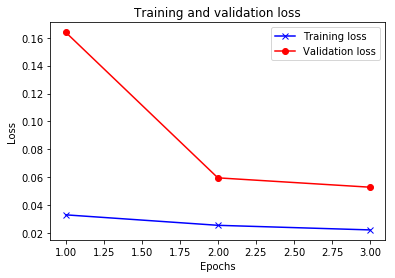

In [36]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot([1, 2, 3], [0.0331, 0.0256, 0.0223], 'bx-', label='Training loss')
# b is for "solid blue line"
plt.plot([1, 2, 3], [0.1639, 0.0596, 0.0529], 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()